In [ ]:
# --- Import of Libarys ---
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# --- 'Translating' Data into readabel Numbers ---
data_titanic = pd.read_csv('./titanic.csv')

data_titanic['Sex'] = data_titanic['Sex'].map({'male':0,'female':1}) # setting Strings to a Messable Number

age_median = data_titanic['Age'].median() # Calculating the Median of the age
data_titanic['Age'] = data_titanic['Age'].fillna(age_median) # using the age median to fill unfilled cells 


In [ ]:
# --- Bringing Features on one Level per Standartscale ---
scaler = StandardScaler()
scaled_features = ['Age','Fare']
data_titanic[scaled_features] = scaler.fit_transform(data_titanic[scaled_features])


In [ ]:
# --- Splitting Wordbased Features into Parts ---
data_titanic = pd.get_dummies(data_titanic, columns=['Embarked', 'Pclass'])

In [ ]:
# --- 1. Version Trainingsdata for X & Y ---
y = data_titanic['Survived']
X = data_titanic.drop(['Survived','Ticket','Name','PassengerId', 'Cabin'], axis=1) # using anything except...

In [37]:
# --- Going into a 2. Version ---
#Idea: Using more Features (SibSp // Parch // Name)


In [38]:
# --- Feature Engineering: Extracting Titles ---

# The Name looks like: "Braund, Mr. Owen Harris"
# We extract the part before the dot (.)
data_titanic['Title'] = data_titanic['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

<>:5: SyntaxWarning: "\." is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\."? A raw string is also an option.
<>:5: SyntaxWarning: "\." is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\."? A raw string is also an option.
/var/folders/47/8h98svn929q45ld_8cvmn3kh0000gq/T/ipykernel_87364/2694942907.py:5: SyntaxWarning: "\." is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\."? A raw string is also an option.


In [40]:
# Let's check what titles we found
print("Titles found:", data_titanic['Title'].unique())

Titles found: ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


In [41]:
# --- grouping rare titles into "Other" ---
# (Major, Col, Sir, Don, etc. become "Rare")
rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']

In [42]:
# ---- Correcting Wrong Typing by Replacing ---
data_titanic['Title'] = data_titanic['Title'].replace(rare_titles, 'Rare')
data_titanic['Title'] = data_titanic['Title'].replace('Mlle', 'Miss') # French for Miss
data_titanic['Title'] = data_titanic['Title'].replace('Ms', 'Miss')
data_titanic['Title'] = data_titanic['Title'].replace('Mme', 'Mrs') # French for Mrs

In [43]:
# --- Translating Strings into Readable Data for 2. Version ---
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
data_titanic['Title'] = data_titanic['Title'].map(title_mapping)
# Fill missing with 0 (just in case)
data_titanic['Title'] = data_titanic['Title'].fillna(0)

In [63]:
# --- Feature Engineering: Family Size ---

# Family Size = Siblings + Parents + The person themselves (+1)
data_titanic['FamilySize'] = data_titanic['SibSp'] + data_titanic['Parch'] + 1

# Optional: Create a feature "IsAlone" (Did they travel alone?)
data_titanic['IsAlone'] = 0
data_titanic.loc[data_titanic['FamilySize'] == 1, 'IsAlone'] = 1

In [65]:
# --- 2. Version Trainingsdata for X & Y ---
y = data_titanic['Survived']
X = data_titanic.drop(['Survived', 'Ticket', 'Name', 'PassengerId', 'Cabin'], axis=1)

In [66]:
# --- Decision Tree ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
model = DecisionTreeClassifier() # creating Memory
model.fit(X_train, y_train) #training/fitting the model to my data
prediction = model.predict(X_test) # getting a prediction

In [67]:
# --- Giving an Output ---
tree_accuracy = accuracy_score(y_test, prediction)

print(tree_accuracy)

0.7597765363128491


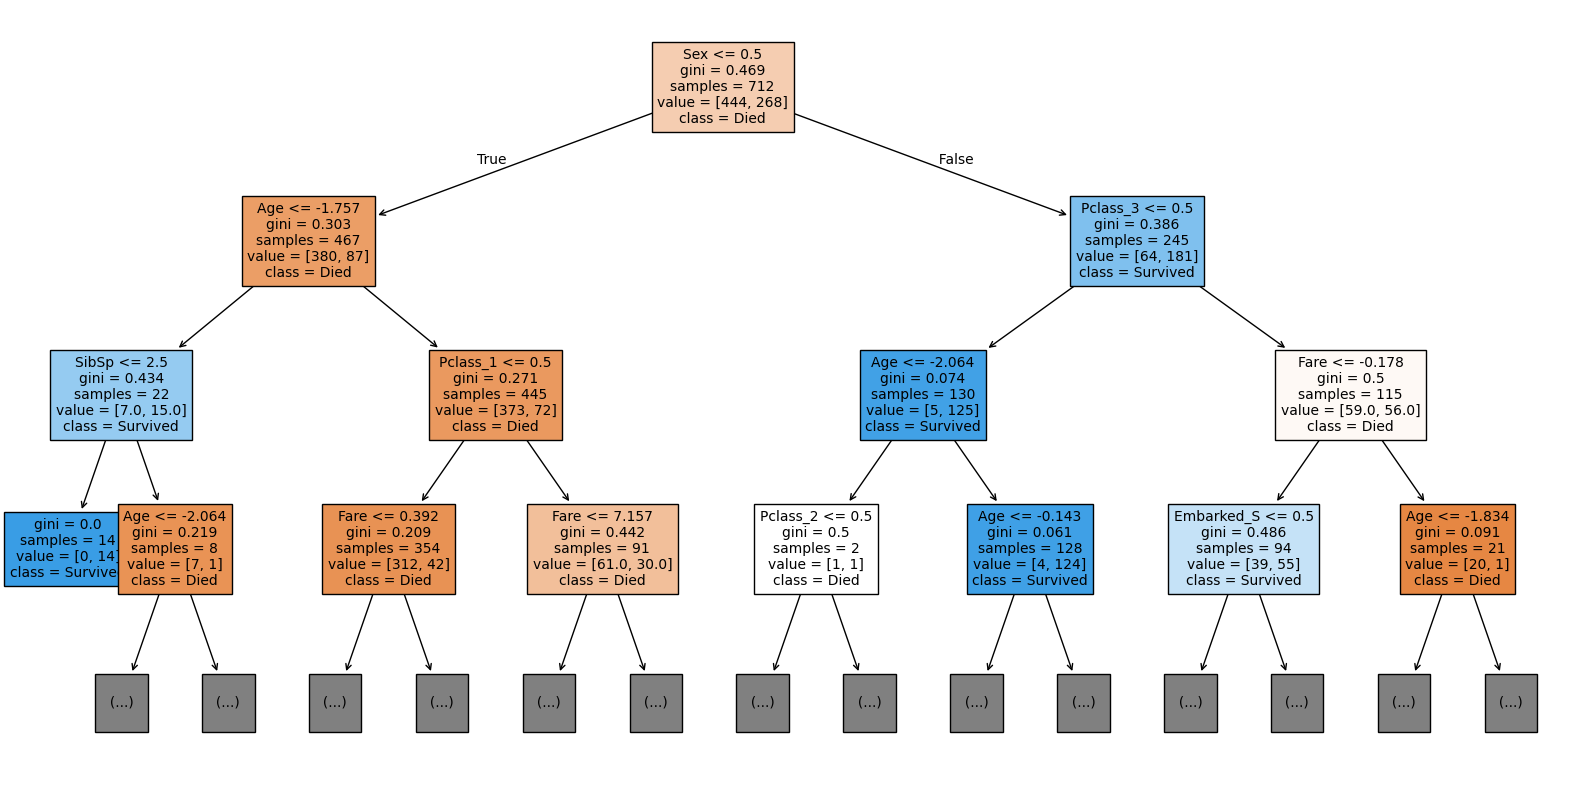

In [26]:
# --- Looking at the generatet Tree ---
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(model, 
          filled=True, 
          feature_names=X.columns,
          class_names=["Died", "Survived"],
          max_depth=3,
          fontsize=10)
plt.show()

In [54]:
# --- Upgrade to Random Forest ---
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
forest_model.fit(X_train,y_train)
forest_prediction = forest_model.predict(X_test)

In [68]:
# --- Comparing // Random Forest ---
forest_accuracy = accuracy_score(y_test, forest_prediction)

print(f"Accuracy Decision Tree: {tree_accuracy:.2%}")
print(f"Accuracy Random Forest:  {forest_accuracy:.2%}")

Accuracy Decision Tree: 75.98%
Accuracy Random Forest:  82.12%


       Feature  Importance
4         Fare    0.235978
1          Age    0.212627
11       Title    0.174614
0          Sex    0.142863
12  FamilySize    0.048412
10    Pclass_3    0.044730
2        SibSp    0.031416
9     Pclass_2    0.021471
3        Parch    0.020428
8     Pclass_1    0.020341
7   Embarked_S    0.016253
5   Embarked_C    0.013574
13     IsAlone    0.009248
6   Embarked_Q    0.008045


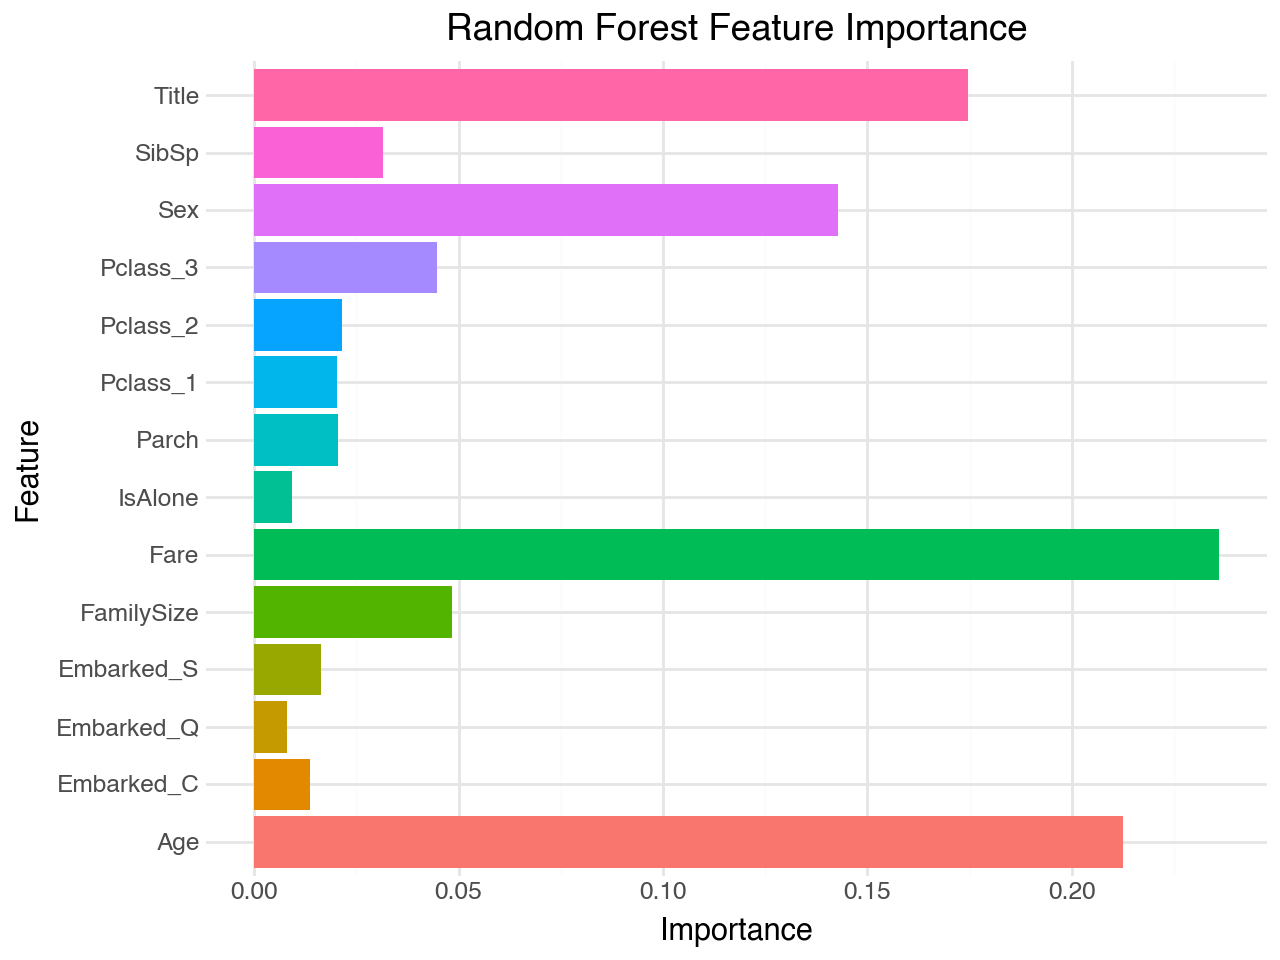

In [69]:
# --- Extracting Feature Importance ---
import plotnine as p9

# Create DataFrame for the plot
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': forest_model.feature_importances_
})

# Sort (so the most important feature is at the top)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display as table
print(importance_df)

# Plotting the graph
(p9.ggplot(importance_df, p9.aes(x='Feature', y='Importance', fill='Feature'))
 + p9.geom_col()
 + p9.coord_flip() # Flips the graph to make feature names readable
 + p9.labs(title="Random Forest Feature Importance", y="Importance", x="Feature")
 + p9.theme_minimal()
 + p9.theme(legend_position='none') # Hide legend, not needed here
)

In [72]:
from sklearn.model_selection import GridSearchCV

# --- Defining the grid ---
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# --- Preparing the search robot ---
# estimator = Random Forest
# param_grid = Who he should test
# cv=5 = Cross-Validation of 5
# n_jobs=-1 = using all prozessors
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2) # shows the prozess

# --- Starting search ---
print("Starting Optimization...")
grid_search.fit(X_train, y_train)

# --- printing the results ---
print("Best Setting Foung:", grid_search.best_params_)
print("Best Accuracy in Training:", grid_search.best_score_)

# --- Testing the best Model ---
best_model = grid_search.best_estimator_
final_prediction = best_model.predict(X_test)

print(f"Final Accuracy Random Forest: {accuracy_score(y_test, final_prediction):.2%}")

Starting Optimization...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.1s
